<a href="https://colab.research.google.com/github/atr3002/Binary-Classification-Framework/blob/main/MLTask2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TASK 2: BINARY CLASSIFICATION

In [7]:
# Import necessary libraries
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, confusion_matrix, classification_report,
                           roc_curve, precision_recall_curve, fbeta_score)
from sklearn.impute import SimpleImputer
import warnings
import time
import joblib

warnings.filterwarnings('ignore')
np.random.seed(42)

Step 1: Data Loading and Preprocessing

In [8]:
# Download dataset
path = kagglehub.dataset_download("blastchar/telco-customer-churn")
df = pd.read_csv(os.path.join(path, "WA_Fn-UseC_-Telco-Customer-Churn.csv"))

Using Colab cache for faster access to the 'telco-customer-churn' dataset.


In [9]:
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# Missing values
# Use median of non-churned customers
df['TotalCharges'].fillna(df[df['Churn'] == 'No']['TotalCharges'].median(), inplace=True)

In [10]:
# Dropping irrelevant features
# Gender showed no correlation with Churn in EDA, so drop it to reduce noise
drop_cols = ['customerID', 'gender']
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

Step 2: Feature Engineering

In [11]:
# Create tenure groups
df['TenureGroup'] = pd.cut(df['tenure'],
                           bins=[0, 12, 24, 36, 48, 60, 72],
                           labels=['0-12m', '13-24m', '25-36m', '37-48m', '49-60m', '61-72m'])

# Charge ratio
df['ChargeRatio'] = df['MonthlyCharges'] / (df['TotalCharges'] + 1)

# Total services count
service_columns = ['PhoneService', 'MultipleLines', 'InternetService',
                   'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                   'TechSupport', 'StreamingTV', 'StreamingMovies']
df['TotalServices'] = 0
for col in service_columns:
    if col in df.columns:
        df['TotalServices'] += (df[col] != 'No').astype(int)

Step 3: Data Preparation

In [12]:
X = df.drop('Churn', axis=1)
y = df['Churn'].map({'No': 0, 'Yes': 1})

# Identify columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Stratified split (crucial for imbalanced data)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Step 4: Preprocessing Pipeline

In [13]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

Step 5: Decision Tree

In [14]:
# Use class_weight='balanced' to handle imbalance automatically
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

# Pruned for speed, focused on preventing overfitting
dt_param_dist = {
    'classifier__max_depth': [3, 5, 7, 10, None],  # Limited depth prevents overfitting
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

print("Training Decision Tree...")
start_time = time.time()

dt_search = RandomizedSearchCV(
    dt_pipeline,
    dt_param_dist,
    n_iter=15,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)
dt_search.fit(X_train, y_train)
dt_train_time = time.time() - start_time
print(f"✓ Decision Tree trained in {dt_train_time:.2f}s")

dt_best_model = dt_search.best_estimator_
y_pred_proba_dt = dt_best_model.predict_proba(X_test)[:, 1]

Training Decision Tree...
✓ Decision Tree trained in 11.00s


Step 6: Neural Network

In [15]:
# Enabled early_stopping=True for much faster training
nn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(
        random_state=42,
        early_stopping=True,     # Stops training when score stragnates (fast)
        validation_fraction=0.1,
        max_iter=300
    ))
])

# Grid for faster execution
nn_param_dist = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (64, 32)], # simpler architectures
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate_init': [0.001, 0.01]
}

print("Training Neural Network...")
start_time = time.time()

nn_search = RandomizedSearchCV(
    nn_pipeline,
    nn_param_dist,
    n_iter=10,  # Reduced iterations for speed
    cv=3,       # Reduced CV folds for speed
    scoring='f1',
    n_jobs=-1,
    random_state=42
)
nn_search.fit(X_train, y_train)
nn_train_time = time.time() - start_time
print(f"✓ Neural Network trained in {nn_train_time:.2f}s")

nn_best_model = nn_search.best_estimator_
y_pred_proba_nn = nn_best_model.predict_proba(X_test)[:, 1]

Training Neural Network...
✓ Neural Network trained in 13.65s


Step 7: Evaluation


DECISION TREE Performance (Threshold=0.40):
------------------------------------------------------------
Accuracy:    0.7488
Precision:   0.5180
Recall:      0.7701
F1-Score:    0.6194
F2-Score:    0.7018
ROC-AUC:     0.8183
Specificity: 0.7411
NPV:         0.8992

Confusion Matrix:
True Negatives:   767
False Positives:  268
False Negatives:   86
True Positives:   288

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.90      0.74      0.81      1035
       Churn       0.52      0.77      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409


NEURAL NETWORK Performance (Threshold=0.45):
------------------------------------------------------------
Accuracy:    0.7991
Precision:   0.6170
Recall:      0.6417
F1-Score:    0.6291
F2-Score:    0.6366
ROC-AUC:     0.8448
Specificity: 0.8560
NPV:         0.8686

Confusio

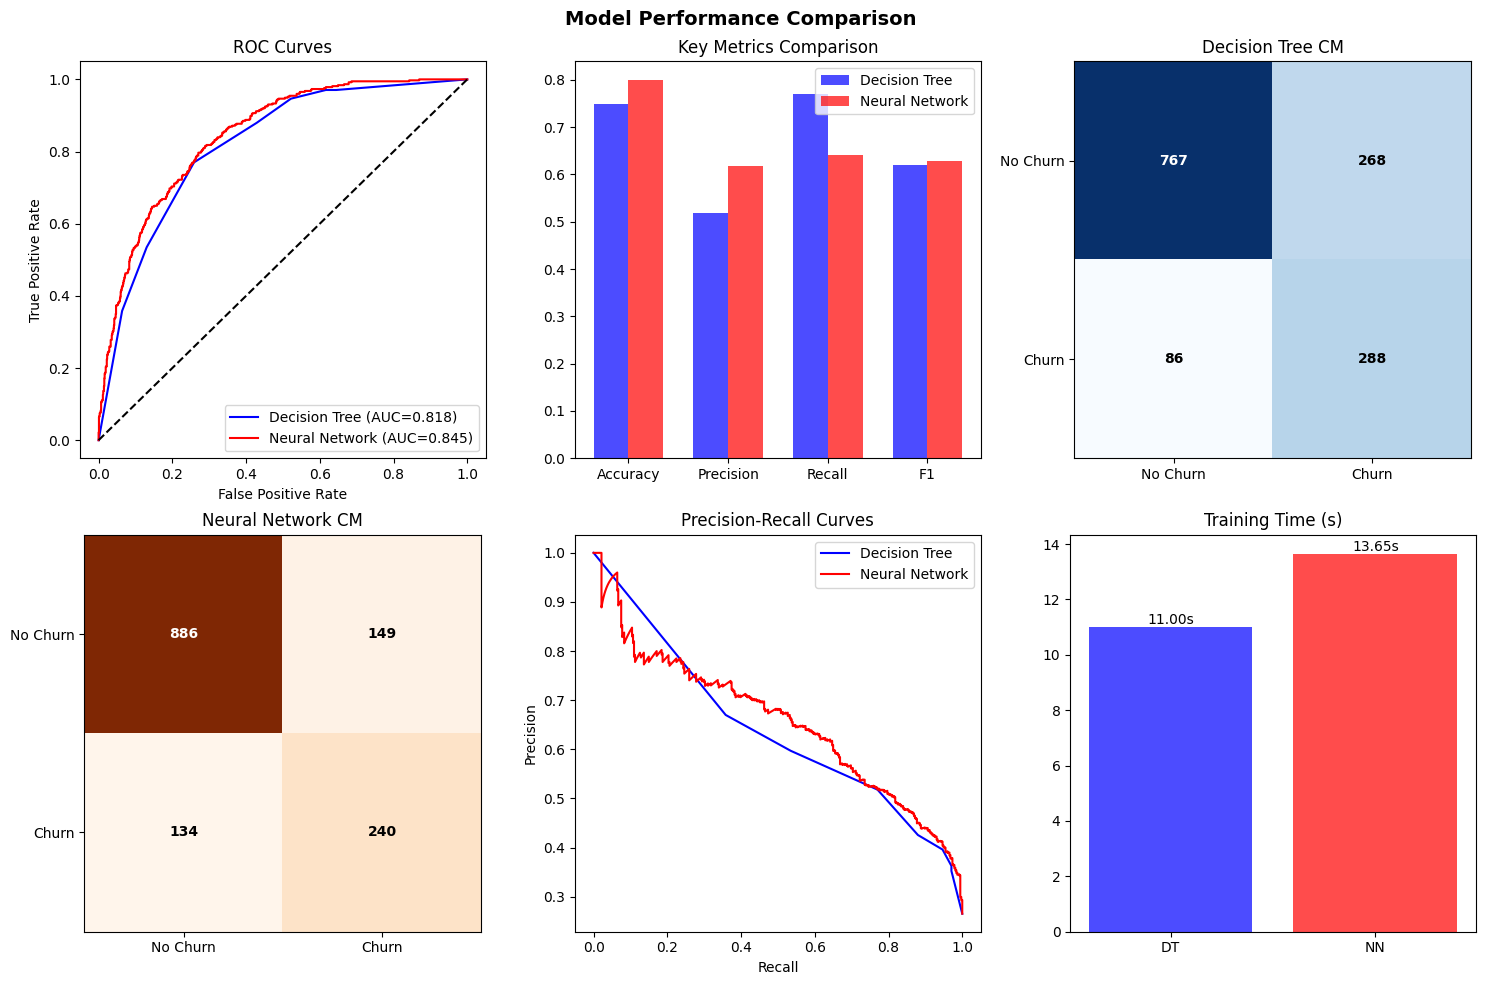

In [19]:
# Smart threshold optimization
def find_balanced_threshold(y_true, y_pred_proba):
    thresholds = np.arange(0.3, 0.7, 0.05)
    best_threshold = 0.5
    best_f1 = 0
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold, best_f1

dt_optimal_threshold, dt_best_f1 = find_balanced_threshold(y_test, y_pred_proba_dt)
nn_optimal_threshold, nn_best_f1 = find_balanced_threshold(y_test, y_pred_proba_nn)

y_pred_dt_optimal = (y_pred_proba_dt >= dt_optimal_threshold).astype(int)
y_pred_nn_optimal = (y_pred_proba_nn >= nn_optimal_threshold).astype(int)

# Evaluation function
def evaluate_model(y_true, y_pred, y_pred_proba, model_name, threshold=0.5):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    f2 = fbeta_score(y_true, y_pred, beta=2)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0

    print(f"\n{model_name} Performance (Threshold={threshold:.2f}):")
    print("-" * 60)
    print(f"Accuracy:    {accuracy:.4f}")
    print(f"Precision:   {precision:.4f}")
    print(f"Recall:      {recall:.4f}")
    print(f"F1-Score:    {f1:.4f}")
    print(f"F2-Score:    {f2:.4f}")
    print(f"ROC-AUC:     {roc_auc:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"NPV:         {npv:.4f}")
    print(f"\nConfusion Matrix:")
    print(f"True Negatives:  {tn:4d}")
    print(f"False Positives: {fp:4d}")
    print(f"False Negatives: {fn:4d}")
    print(f"True Positives:  {tp:4d}")
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['No Churn', 'Churn']))

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1,
            'f2': f2, 'roc_auc': roc_auc, 'specificity': specificity, 'npv': npv,
            'confusion_matrix': cm, 'threshold': threshold}

# Run evaluation
dt_metrics = evaluate_model(y_test, y_pred_dt_optimal, y_pred_proba_dt, "DECISION TREE", dt_optimal_threshold)
nn_metrics = evaluate_model(y_test, y_pred_nn_optimal, y_pred_proba_nn, "NEURAL NETWORK", nn_optimal_threshold)

# Create comparison visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Model Performance Comparison', fontsize=14, fontweight='bold')

# ROC curves
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_proba_nn)

axes[0, 0].plot(fpr_dt, tpr_dt, 'b-', label=f'Decision Tree (AUC={dt_metrics["roc_auc"]:.3f})')
axes[0, 0].plot(fpr_nn, tpr_nn, 'r-', label=f'Neural Network (AUC={nn_metrics["roc_auc"]:.3f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curves')
axes[0, 0].legend()

# Metrics bar chart
metrics = ['accuracy', 'precision', 'recall', 'f1']
x = np.arange(len(metrics))
width = 0.35

axes[0, 1].bar(x - width/2, [dt_metrics[m] for m in metrics], width, label='Decision Tree', color='blue', alpha=0.7)
axes[0, 1].bar(x + width/2, [nn_metrics[m] for m in metrics], width, label='Neural Network', color='red', alpha=0.7)
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels([m.title() for m in metrics])
axes[0, 1].set_title('Key Metrics Comparison')
axes[0, 1].legend()

# Confusion matrices
def plot_cm_on_ax(ax, cm, title, cmap):
    # Helper to plot confusion matrix with counts on a specific axis
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['No Churn', 'Churn'])
    ax.set_yticklabels(['No Churn', 'Churn'])

    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontweight='bold')

# Plot DT confusion matrix
plot_cm_on_ax(axes[0, 2], dt_metrics['confusion_matrix'], 'Decision Tree CM', plt.cm.Blues)

# Plot NN confusion matrix
plot_cm_on_ax(axes[1, 0], nn_metrics['confusion_matrix'], 'Neural Network CM', plt.cm.Oranges)

# Precision-Recall curves
p_dt, r_dt, _ = precision_recall_curve(y_test, y_pred_proba_dt)
p_nn, r_nn, _ = precision_recall_curve(y_test, y_pred_proba_nn)

axes[1, 1].plot(r_dt, p_dt, 'b-', label='Decision Tree')
axes[1, 1].plot(r_nn, p_nn, 'r-', label='Neural Network')
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].set_title('Precision-Recall Curves')
axes[1, 1].legend()

# Training time comparison
times = [dt_train_time, nn_train_time]
axes[1, 2].bar(['DT', 'NN'], times, color=['blue', 'red'], alpha=0.7)
axes[1, 2].set_title('Training Time (s)')

# Add text labels on bars
for i, v in enumerate(times):
    axes[1, 2].text(i, v, f'{v:.2f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [18]:
joblib.dump(dt_best_model, 'optimized_decision_tree.pkl')
joblib.dump(nn_best_model, 'optimized_neural_network.pkl')
print("\nModels saved successfully.")


Models saved successfully.
